# Structured Variational Message Passing for Estimation

In this demo we compare mean-field VMP with structured VMP. We consider a continuous state-space model similar to the one defined in the first and second demo. Initially, we assumed the state evolution noise observed. In the present demo, we are interested in estimating the hidden state in conjunction with the state evolution precision. We assume the observation variance known.

\begin{align*}
    s_t &\sim \mathcal{N}(s_{t-1}, w^{-1})\\
    x_t &\sim \mathcal{N}(s_t, v)\,.
\end{align*}

We choose vague priors

\begin{align*}
    s_0 &\sim \mathcal{N}(0, 100)\\
    w &\sim \mathcal{G}am(0.01, 0.01)\,.
\end{align*}

## Generate toy dataset

In [1]:
n_samples = 100
v_data = 1.0
w_data = 10.0
s_0_data = 0.0

s_data = Vector{Float64}(undef, n_samples)
x_data = Vector{Float64}(undef, n_samples)
s_t_min_data = s_0_data
for t = 1:n_samples
    s_data[t] = s_t_min_data + sqrt(1/w_data)*randn() # Evolution model
    x_data[t] = s_data[t] + sqrt(v_data)*randn() # Observation model
    
    s_t_min_data = s_data[t]
end
;

## Model specification

In [2]:
using ForneyLab

g = FactorGraph()

@RV w ~ Gamma(0.01, 0.01)
@RV s_0 ~ GaussianMeanVariance(0.0, 100.0)

s = Vector{Variable}(undef, n_samples)
x = Vector{Variable}(undef, n_samples)
s_t_min = s_0
for t = 1:n_samples
    @RV s[t] ~ GaussianMeanPrecision(s_t_min, w)
    @RV x[t] ~ GaussianMeanVariance(s[t], v_data)
    
    s_t_min = s[t]
    
    placeholder(x[t], :x, index=t)
end
;

┌ Info: Precompiling ForneyLab [9fc3f58a-c2cc-5bff-9419-6a294fefdca9]
└ @ Base loading.jl:1273


## Mean-field algorithm generation

First we schedule the mean-field algorithm, which fully factorizes the recognition distribution as

\begin{align*}
    q(w, s_0, \dots, s_T) = q(w)\prod_{t=0}^T q(s_t)
\end{align*}

In [3]:
# Define recognition factorization
algo_mf = Algorithm(:MF)
q_w = RecognitionFactor(w, id=:W)
q_s_0 = RecognitionFactor(s_0, id=:S_0)

q_s = Vector{RecognitionFactor}(undef, n_samples)
for t=1:n_samples
    q_s[t] = RecognitionFactor(s[t],id=:S_*t)
end

# Compile algorithm
variationalAlgorithm(algo_mf, free_energy=true)

# Generate source code
code_mf = algorithmSourceCode(algo_mf, free_energy=true);

## Mean-field execution

In [4]:
# Load algorithm
eval(Meta.parse(code_mf))

# Initialize data
data = Dict(:x => x_data)
n_its = 40

# Initial recognition distributions
marginals_mf = Dict{Symbol, ProbabilityDistribution}(:w => vague(Gamma))
for t = 0:n_samples
    marginals_mf[:s_*t] = vague(GaussianMeanPrecision)
end

# Run algorithm
F_mf = Vector{Float64}(undef, n_its)
for i = 1:n_its
    for k = 0:n_samples
        step!(:MFS_*k, data, marginals_mf)
        stepMFW!(data, marginals_mf)
    end

    F_mf[i] = freeEnergyMF(data, marginals_mf)
end
;

## Structured algorithm generation

The structured algorithm retains the state-dependencies in the recognition factorization

\begin{align*}
    q(w, s_0, \dots, s_T) = q(w)\times q(s_0, \dots, s_T)\,.
\end{align*}

In [5]:
# Compile algorithm
algo_struct = variationalAlgorithm(w, [s_0; s]; ids=[:W, :S], id=:Struct, free_energy=true)

# Generate source code
code_struct = algorithmSourceCode(algo_struct, free_energy=true);

## Structured execution

In [6]:
# Load algorithm
eval(Meta.parse(code_struct))

# Initial recognition distributions
marginals_struct = Dict{Symbol, ProbabilityDistribution}(:w => vague(Gamma))

# Run algorithm
F_struct = Vector{Float64}(undef, n_its)
for i = 1:n_its
    stepStructS!(data, marginals_struct)
    stepStructW!(data, marginals_struct)

    F_struct[i] = freeEnergyStruct(data, marginals_struct)
end
;

## Results

The results show a smoother fit for the state estimates of the structured algorithm. Inspecting the free energy, the plot for structured algorithm eventually dives below the plot for the mean-field algorithm, indicating the smoother fit to be a better explanation for the data.

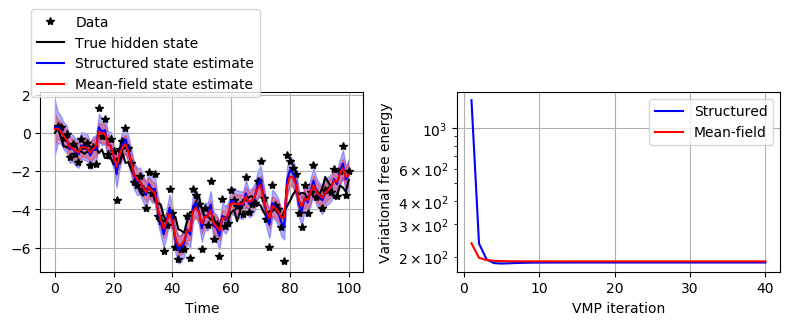

In [7]:
using PyPlot

# Collect state estimates
m_s_mf = [mean(marginals_mf[:s_*t]) for t=0:n_samples]
v_s_mf = [var(marginals_mf[:s_*t]) for t=0:n_samples]
m_s_struct = [mean(marginals_struct[:s_*t]) for t=0:n_samples]
v_s_struct = [var(marginals_struct[:s_*t]) for t=0:n_samples]

# Plot estimated state
figure(figsize=(8,4))
subplot(121)
plot(collect(1:n_samples), x_data, "*", label="Data", color="black")
plot(collect(0:n_samples), [0.0; s_data], "k-", label="True hidden state")
plot(collect(0:n_samples), m_s_struct, "b-", label="Structured state estimate")
fill_between(collect(0:n_samples), m_s_struct-sqrt.(v_s_struct), m_s_struct+sqrt.(v_s_struct), color="b", alpha=0.3);
plot(collect(0:n_samples), m_s_mf, "r-", label="Mean-field state estimate")
fill_between(collect(0:n_samples), m_s_mf-sqrt.(v_s_mf), m_s_mf+sqrt.(v_s_mf), color="r", alpha=0.3);
grid("on")
xlabel("Time")
legend(loc="upper left", bbox_to_anchor=[-0.05, 1.5]);

subplot(122)
plot(1:n_its, F_struct, color="blue", label="Structured")
plot(1:n_its, F_mf, color="red", label="Mean-field")
grid("on")
legend()
yscale("log")
xlabel("VMP iteration")
ylabel("Variational free energy")
tight_layout();